In [1]:
from pycwr.io import read_auto
import os
import numpy as np
import matplotlib.pyplot as plt
import attenuation

path = '/Users/xiaowu/Library/Mobile Documents/com~apple~CloudDocs/work/MeteoDataFusion'
infile = os.path.join(path,'test','data','Z9002.20220425.060745.AR2.bz2')

PRD = read_auto(infile)

PyartRadar = PRD.ToPyartRadar()

sweep = 2
ref = PyartRadar.fields['reflectivity']['data'][PyartRadar.get_slice(sweep)]
kdp = PyartRadar.fields['specific_differential_phase']['data'][PyartRadar.get_slice(sweep)]

gate_length = PyartRadar.range['meters_between_gates'] / 1000.
print(gate_length)

#Unconstrained gate-by-gate retrieval (1954)
pia_hb = attenuation.correct_attenuation_hb(gateset = ref, coefficients={"a" :  1.67e-4, "b" : 0.7,\
    "gate_length": gate_length}, mode="nan", thrs=59.0)
pia_kraemer = attenuation.correct_attenuation_constrained(
    ref,
    a_max=1.67e-4,
    a_min=2.33e-5,
    n_a=100,
    b_max=0.7,
    b_min=0.65,
    n_b=6,
    gate_length=1.0,
    constraints=[attenuation.constraint_dbz],
    constraint_args=[[59.0]],
)
pia_mkraemer = attenuation.correct_attenuation_constrained(
    ref,
    a_max=1.67e-4,
    a_min=2.33e-5,
    n_a=100,
    b_max=0.7,
    b_min=0.65,
    n_b=6,
    gate_length=1.0,
    constraints=[attenuation.constraint_dbz, attenuation.constraint_pia],
    constraint_args=[[59.0], [20.0]],
)
pia_kdp = attenuation.pia_from_kdp(kdp, dr = gate_length, gamma=0.08)
print(np.count_nonzero(pia_hb))

0.25


/Users/xiaowu/Library/Mobile Documents/com~apple~CloudDocs/work/MeteoDataFusion/attenuation.py:80: RuntimeWarning: overflow encountered in power
  k = a * (10.0 ** ((gateset[..., gate] + ksum) / 10.0)) ** b * 2.0 * gate_length
/Users/xiaowu/Library/Mobile Documents/com~apple~CloudDocs/work/MeteoDataFusion/attenuation.py:543: RuntimeWarning: overflow encountered in power
  return 10.0 ** (x / 10.0)


480116


In [2]:
x, y, z = PyartRadar.get_gate_x_y_z(sweep, edges = False, filter_transitions = True)

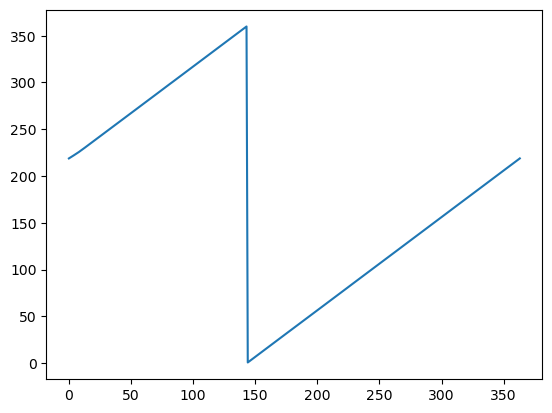

In [3]:
azi = PyartRadar.azimuth['data'][PyartRadar.get_slice(sweep)]
plt.plot(azi)


/var/folders/8p/1s_25tdx2nxc6ffrjn_stzsm0000gn/T/ipykernel_70012/1570888645.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pmesh = ax1.pcolormesh(x / 1000., y / 1000., ref, cmap='viridis')
/var/folders/8p/1s_25tdx2nxc6ffrjn_stzsm0000gn/T/ipykernel_70012/1570888645.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pmesh = ax2.pcolormesh(x / 1000., y / 1000., pia_kdp)


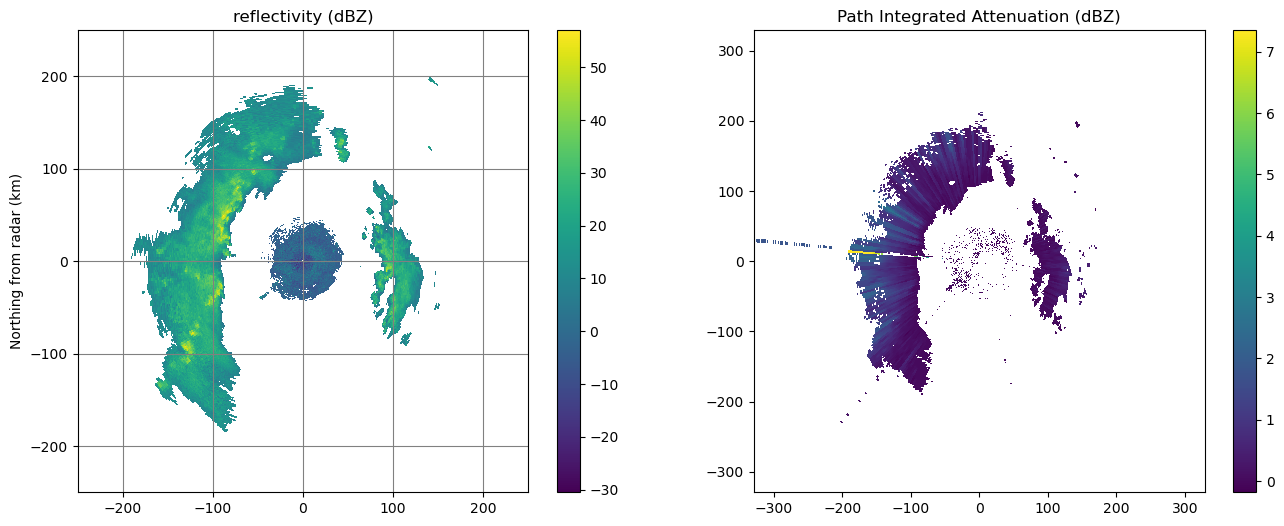

In [17]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)

pmesh = ax1.pcolormesh(x / 1000., y / 1000., ref, cmap='viridis')
ax1.set_ylabel("Northing from radar (km)")
ax1.set_title("reflectivity (dBZ)")
ax1.grid(color="grey")
fig.colorbar(mappable=pmesh, ax=ax1)

ax1.set_xlim(-250,250)
ax1.set_ylim(-250,250)
ax2 = fig.add_subplot(1,2,2)
pmesh = ax2.pcolormesh(x / 1000., y / 1000., pia_kdp)
ax2.set_title("Path Integrated Attenuation (dBZ)")
fig.colorbar(mappable=pmesh, ax=ax2)

In [22]:
def plot_beams(data, mybeams, sub=111):
    ax = fig.add_subplot(sub)
    labelsize = 13

    for beam in range(mybeams.start, mybeams.stop):
        x = np.arange(data[beam].shape[-1]) * gate_length 
        plt.plot(x, data[beam], label="{0} deg".format(int(azi[beam]))) # 0代表位置0
    plt.grid()
    plt.text(
        0.99,
        0.88,
        "Reflectivity along beams",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize="large",
    )
    plt.xlabel("range (km)", fontsize="large")
    plt.ylabel("Reflectivity (dBZ)", fontsize="large")
    plt.legend(loc="upper left")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.xlim(0,180)

def plot_pia(pia, sub=111, title=None):
    ax = fig.add_subplot(sub)
    labelsize = 13
    x = np.arange(pia.shape[-1]) * gate_length 
    plt.plot(x, pia.T)
    plt.grid()
    plt.xlim(0,180)
    plt.ylim(0, 30)
    plt.ylabel("PIA (dB)", fontsize="large")
    plt.text(0.01, 0.88, title, transform=ax.transAxes, fontsize="large")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)


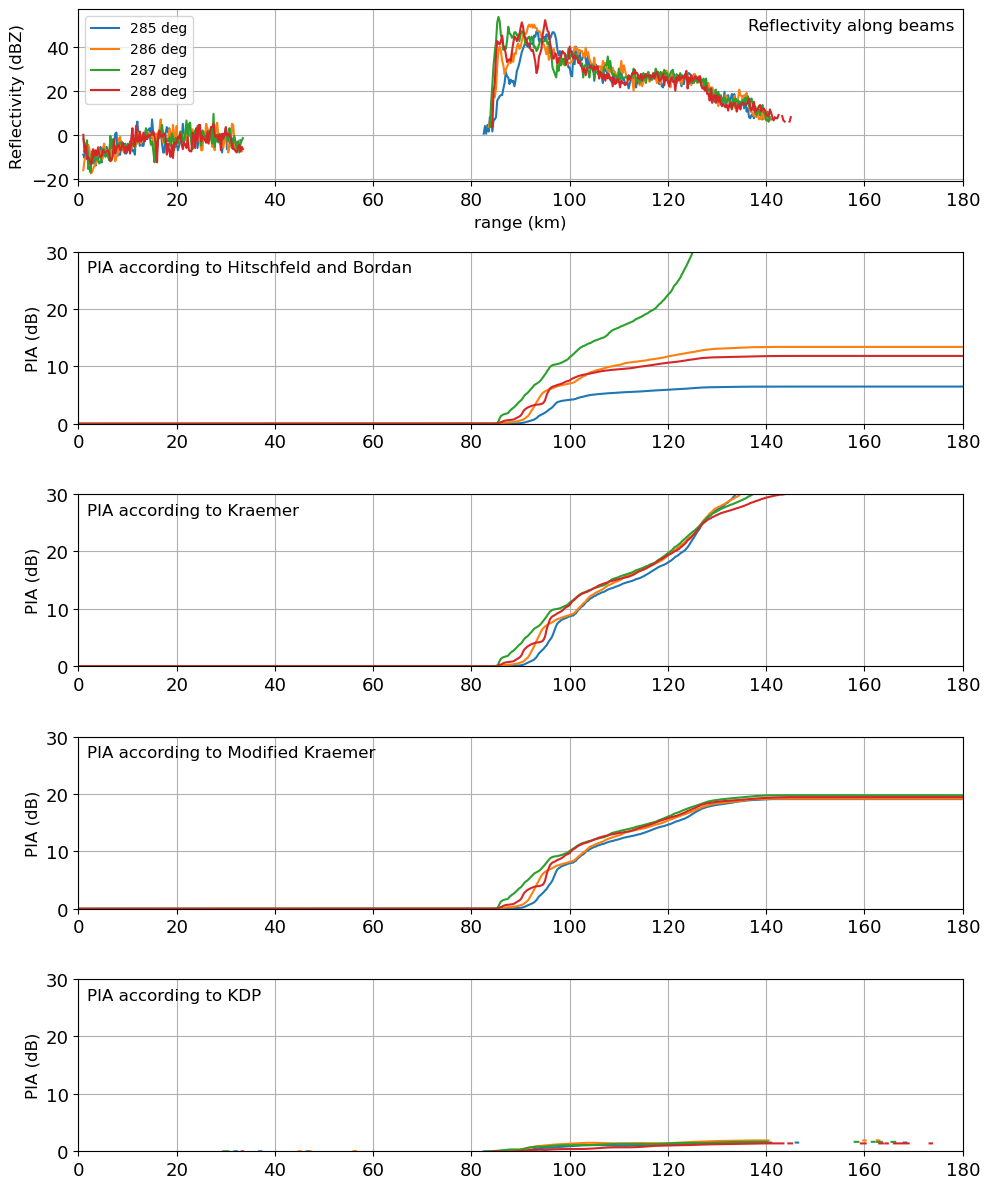

In [23]:
mybeams = slice(68,72)
fig = plt.figure(figsize=(10, 12))
plot_beams(ref, mybeams, 511)
plot_pia(pia_hb[mybeams], 512, "PIA according to Hitschfeld and Bordan")
plot_pia(pia_kraemer[mybeams], 513, "PIA according to Kraemer")
plot_pia(pia_mkraemer[mybeams], 514, "PIA according to Modified Kraemer")
plot_pia(pia_kdp[mybeams], 515, "PIA according to KDP")
plt.tight_layout()


In [7]:
print(PyartRadar.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (3261,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (3261,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	velocity:
		data: <ndarray of type: float64 and shape: (3261, 1320)>
		units: meters_per_second
		standard_name: radial_velocity_of_scatterers_away_from_instrument
		long_name: Mean dopper velocity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	spectrum_width:
		data: <ndarray of type: floa

In [8]:
print(PyartRadar.elevation['data'])

[ 0.5         0.5         0.5        ... 19.53000069 19.53000069
 19.53000069]


In [9]:
PyartRadar.instrument_parameters.keys()

dict_keys(['pulse_width', 'radar_beam_width_h', 'radar_beam_width_v', 'frequency', 'nyquist_velocity'])

In [10]:
PyartRadar.instrument_parameters['radar_beam_width_h']

{'units': 'degrees',
 'meta_group': 'radar_parameters',
 'long_name': 'Antenna beam width H polarization',
 'data': array([0.952], dtype=float32)}

In [11]:
PyartRadar.fields.keys()

dict_keys(['velocity', 'spectrum_width', 'total_power', 'reflectivity', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'specific_differential_phase', 'horizontal_signal_noise_ratio'])

In [12]:
gate_length * np.arange(ref[2].shape[-1]) * 250 / 1000

array([0.00000e+00, 6.25000e-02, 1.25000e-01, ..., 8.23125e+01,
       8.23750e+01, 8.24375e+01])

In [13]:
pia.shape

NameError: name 'pia' is not defined

In [ ]:
ksum = 0.0
k = 1.67e-4 * (10.0 ** ((ref[..., 4] + ksum) / 10.0)) ** 0.7 * 2.0 * gate_length
ksum += k

In [ ]:
ref[..., 10]

masked_array(data=[-12.5, -19.0, -17.0, -22.5, -15.5, -17.0, -18.0, -28.5,
                   -16.5, -10.0, -12.0, -14.5, -18.0, -21.0, -8.5, -12.0,
                   -18.0, -20.0, -13.0, -17.5, -11.0, -17.5, -12.0, -16.0,
                   -7.5, -13.0, -8.0, -16.5, -16.0, -15.0, -27.5, -11.5,
                   -18.0, -20.5, -11.0, -9.5, -15.0, -12.5, -9.0, -16.5,
                   -12.5, -1.0, -12.5, -8.5, -18.0, -7.5, -4.0, -0.5,
                   -7.0, -12.0, -12.5, -4.5, -8.5, -10.0, -10.5, -12.5,
                   -18.0, -13.5, -4.0, -11.0, -8.5, -13.0, -10.5, -12.5,
                   -6.5, -5.5, -13.0, -6.5, -9.0, -17.5, -17.0, -13.5,
                   -8.0, -12.0, -9.5, -6.5, -11.0, -14.0, -10.5, -7.0,
                   -10.0, -15.0, -9.0, -4.5, -9.5, -14.5, -7.0, -7.5,
                   -13.5, -7.0, -5.0, -6.0, -10.5, -10.0, -17.0, -21.0,
                   -3.5, -9.5, -16.0, -7.5, -6.0, -9.0, -6.5, -5.0, -5.5,
                   -13.0, -11.0, -9.5, -7.0, -7.5, -18.0,